## **Toxicity Classification:**
#### **1.Business Problem**
**Source:**[Dataset](https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/data)<br>
**Description:**[Description](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/description)

**Problem Statement:** Given a comment made by the user, predict the toxicity of the comment.


In [40]:
!pip install gensim

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns 
import scipy # this library used for scientific computation 
from wordcloud import WordCloud, STOPWORDS

import nltk
#The nltk.corpus package difines a colllection of corpus readr classes, which can be used to access the contents of a diverse set of corpora.
from nltk.corpus import stopwords
#to do the things properly with the use of vocabulary and morphological analysis of words.
from nltk.stem import SnowballStemmer, PorterStemmer #PorterStemming is a process fro removing the commoner morphologocal and inflexion endings from words in english.

import math
from collections import Counter
#from sklearn.feature_extraction.text import TfidVectorizer, CountVectorizer

#Gensim is designed to process raw, unstructured digital texts (plain text) using unsupervised ml algorithm
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import warnings
warnings.filterwarnings("ignore")


## **Reading Data**

In [42]:
train=pd.read_csv('train.csv',index_col='id')
train.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [43]:
test_df=pd.read_csv('test.csv',index_col='id')
test_df.head()


,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [44]:
train.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


**Looking at count values of asian, atheist etc columns we see that there are alot of null values present, but this is ok as we are only supposed to use 'comment_text' variable dealing with these is not really necessary here** 

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                       

In [46]:
print(train.shape)
print(test_df.shape)

(1804874, 44)
(97320, 1)


## **Exploratory Data Analysis & Visualization**<br>
**1.Target Feature:**

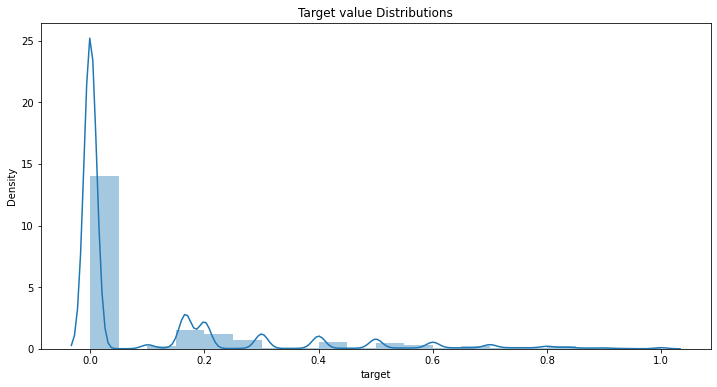

In [47]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train['target'],kde=True,bins=20,label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic(<0.5) and only a few of them are actually toxic(>0.5)**

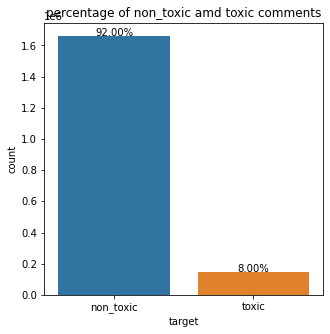

In [48]:
#if toxicity rating <0.5 then the comment is non-toxic else it's toxic.
#Get toxic and non_toxic comments.
temp=train['target'].apply(lambda x: "non_toxic" if x <0.5 else "toxic")

#plot the number and percentage of toxic and non-toxic comments.
fig, ax=plt.subplots(1,1, figsize=(5,5))
total=float(len(temp))

#plot the count bar
cntplot=sns.countplot(temp)
cntplot.set_title('percentage of non_toxic amd toxic comments')

#get the height and calculate the percentrage then display it the plot itself
for p in ax.patches:
  #get height
  height=p.get_height()
  #plot at appropriate position
  ax.text(p.get_x()+p.get_width()/2.0, height + 3,'{:1.2f}%'.format(100*height/total), ha='center')


**The dataset is imbalanced as 92% of the comments are non_toxic nd only 8% are toxic.**


**We'll do analysis on `Toxicity Subtype Feature` for dependent and independent variable**

In [49]:
#creating a function to plot the distribueion
def features_dist(features,title,data):
  plt.figure(figsize=(15,6))
  plt.title(title)

  for feature in features:
    sns.distplot(data[feature],kde=True,hist=False, bins=240,label=feature)
  plt.xlabel('')
  plt.legend()
  plt.show()

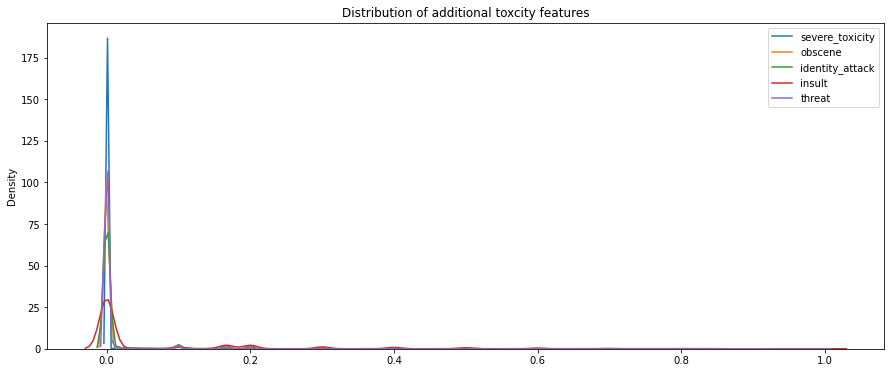

In [50]:
features=['severe_toxicity','obscene','identity_attack','insult','threat']
features_dist(features,"Distribution of additional toxcity features",train)

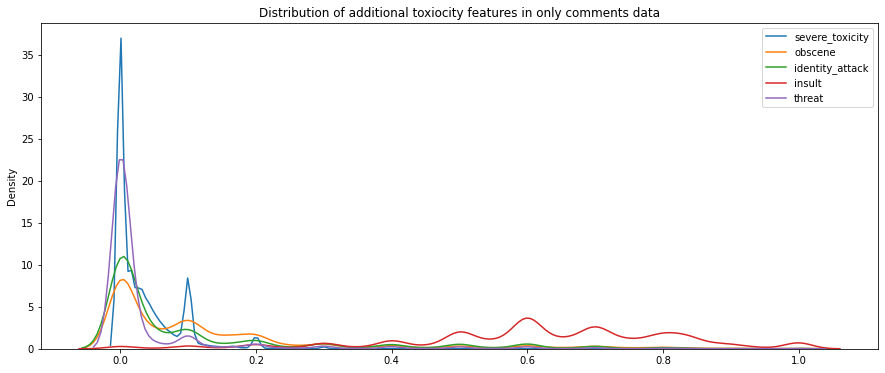

In [51]:
#looking at the distribution of additional toxicity features on the comments that are actually considered toxic
temp=train[train['target']>0.5]
features_dist(features,"Distribution of additional toxiocity features in only comments data",temp)

We see that for tocic comments data, they are more insulting comments as compared to obscene comments.

**We'll start analysis on identtity Attributes feature**

In [52]:
temp =train.dropna(axis=0,how='any')

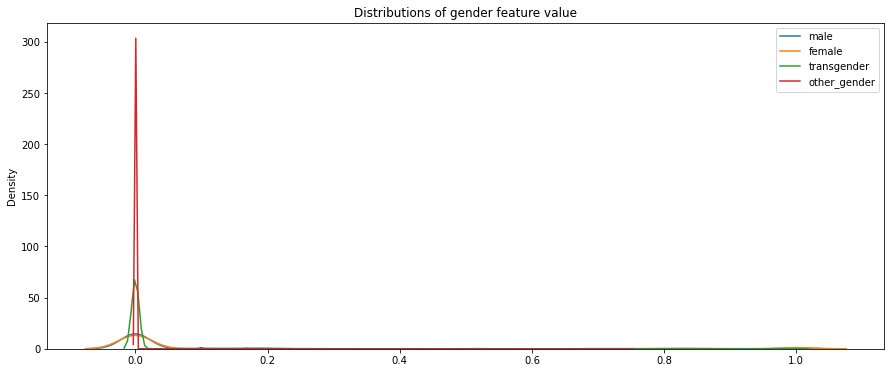

In [53]:
features=['male','female','transgender','other_gender']
features_dist(features,"Distributions of gender feature value",temp)

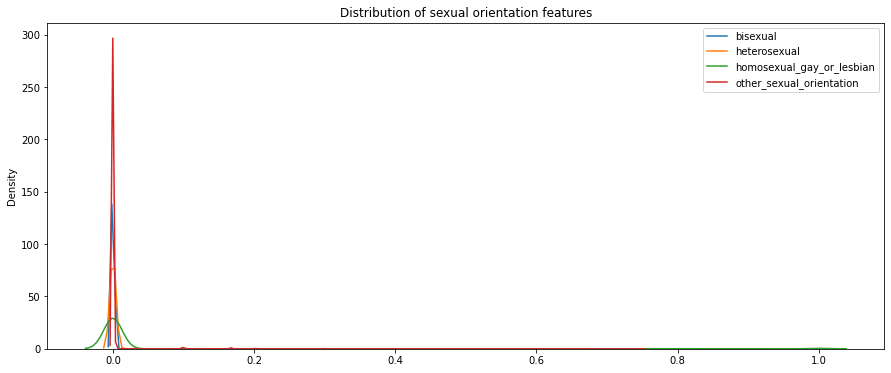

In [54]:
features=['bisexual','heterosexual','homosexual_gay_or_lesbian','other_sexual_orientation']
features_dist(features,"Distribution of sexual orientation features",temp)

**We'll do analysis on Feedback Generated By User.**

In [55]:
def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(6*size,6))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()  

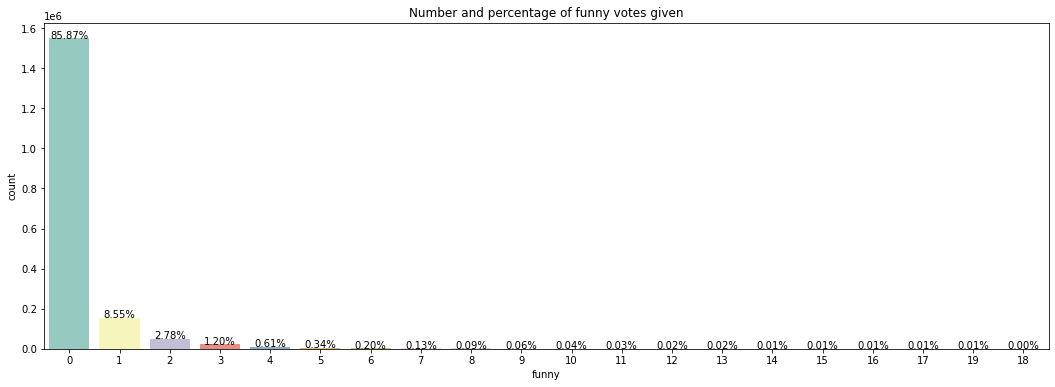

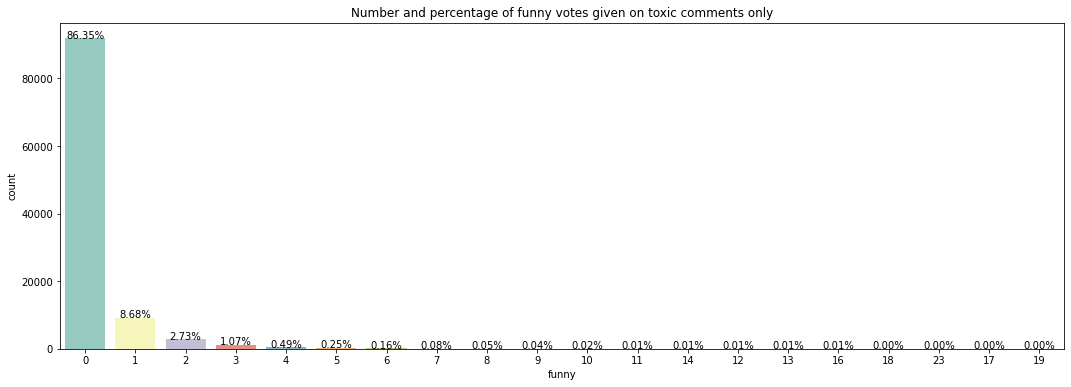

In [56]:
plot_count('funny','funny votes given', train, 3)
plot_count('funny', 'funny votes given on toxic comments only', train[train['target'] > 0.5], 3)

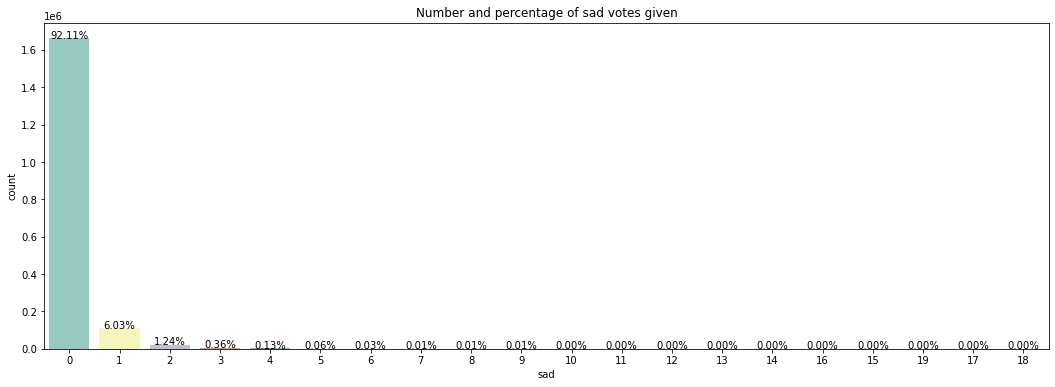

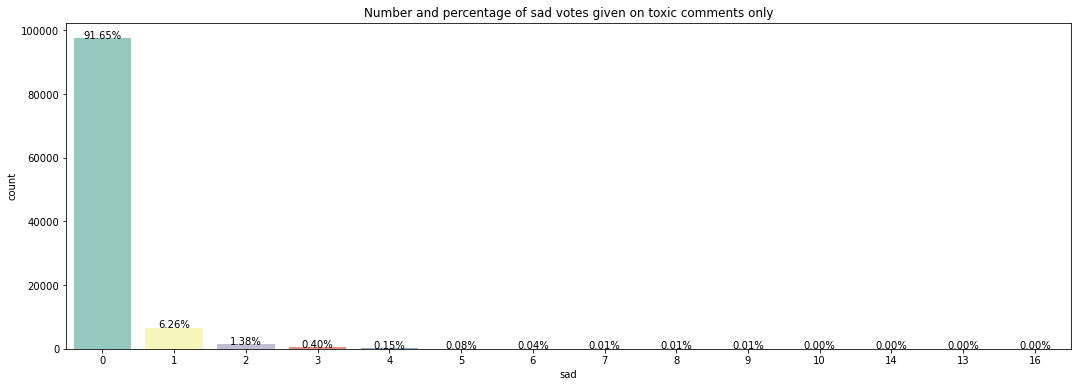

In [57]:
plot_count('sad','sad votes given', train, 3)
plot_count('sad', 'sad votes given on toxic comments only', train[train['target'] > 0.5], 3)

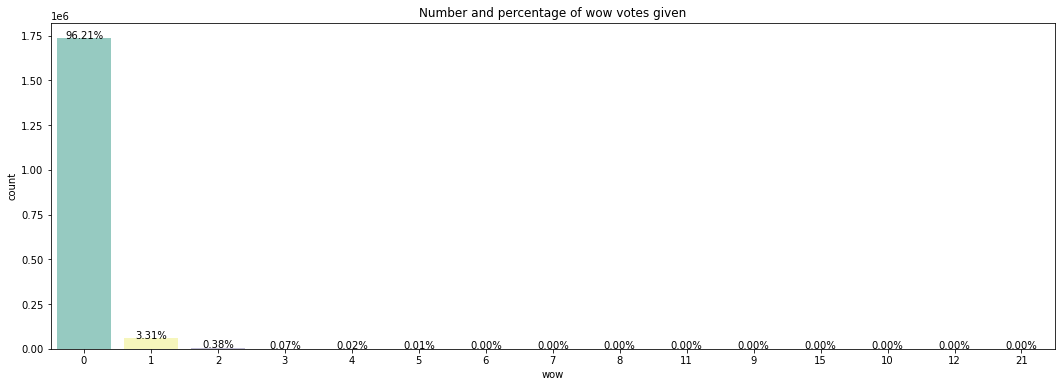

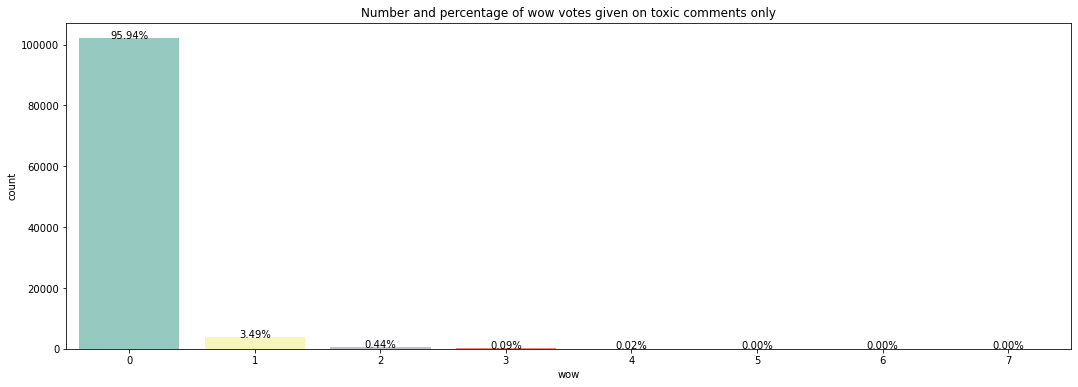

In [58]:
plot_count('wow','wow votes given', train, 3)
plot_count('wow', 'wow votes given on toxic comments only', train[train['target'] > 0.5], 3)

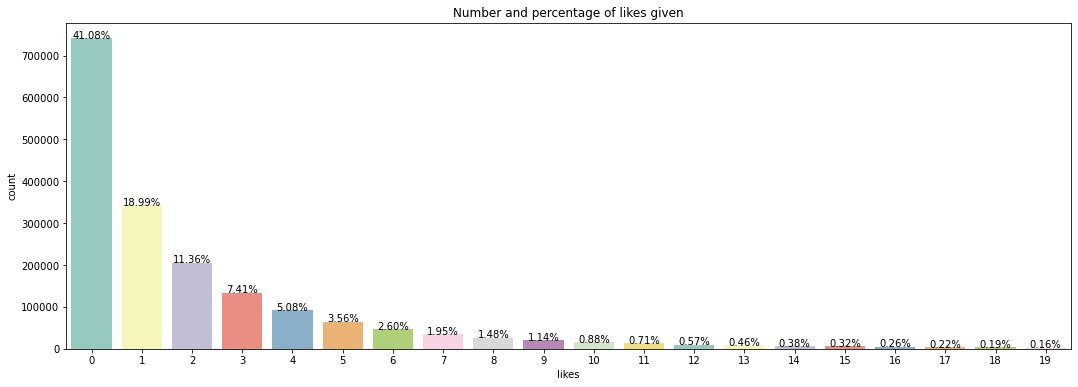

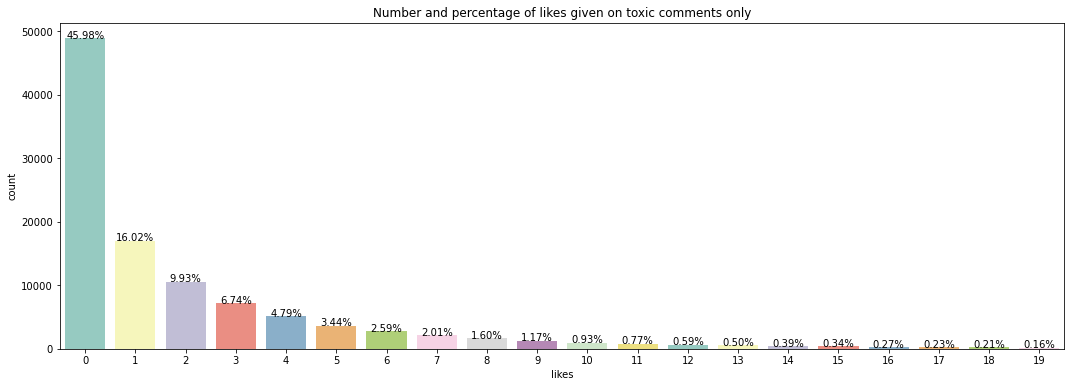

In [59]:
plot_count('likes','likes given', train, 3)
plot_count('likes', 'likes given on toxic comments only', train[train['target'] > 0.5], 3)

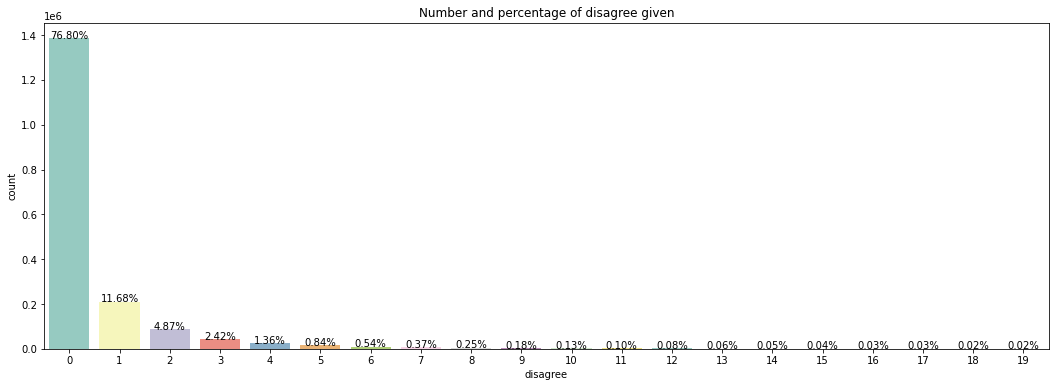

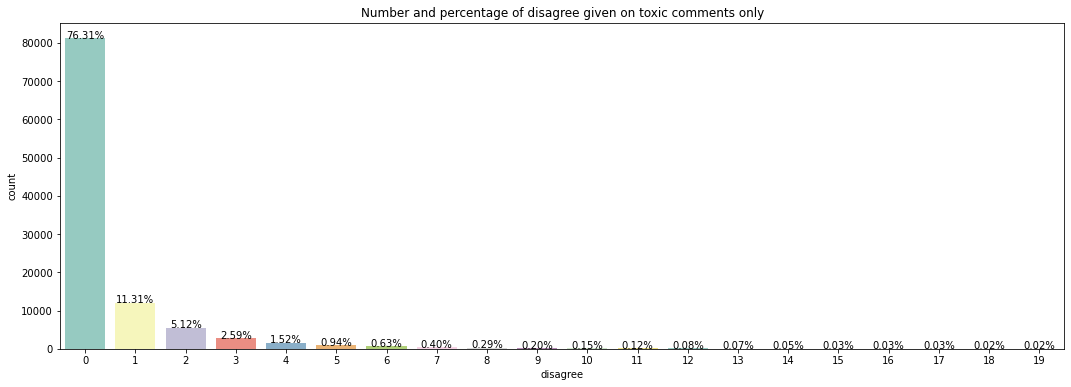

In [60]:
plot_count('disagree','disagree given', train, 3)
plot_count('disagree', 'disagree given on toxic comments only', train[train['target'] > 0.5], 3)

##**We'll do visualize the `Comment_text Feature`.**

In [61]:
#creating a manual function to reduce the rewrting the code for each individual comments.
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

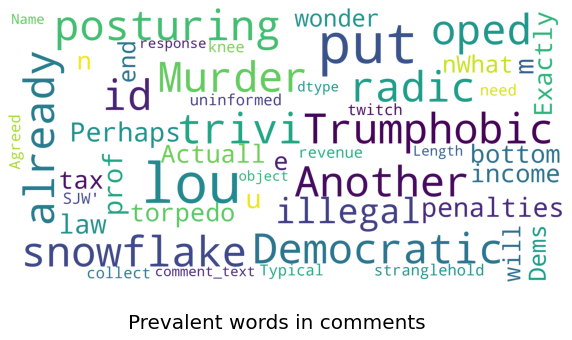

In [62]:
show_wordcloud(train['comment_text'].sample(20000),title='Prevalent words in comments')

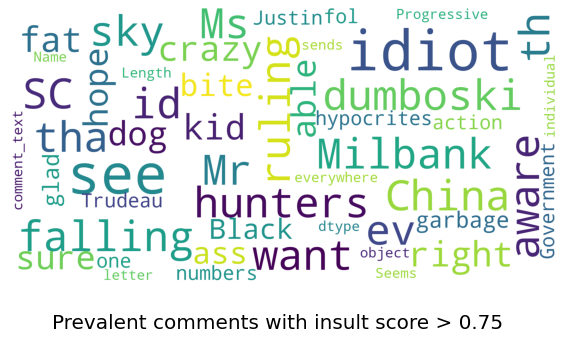

In [63]:
show_wordcloud(train.loc[train['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

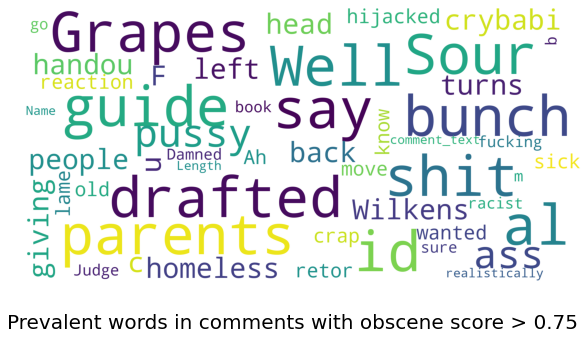

In [64]:
show_wordcloud(train.loc[train['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

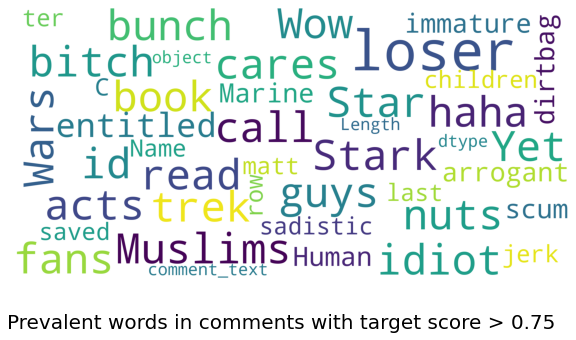

In [65]:
show_wordcloud(train.loc[train['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

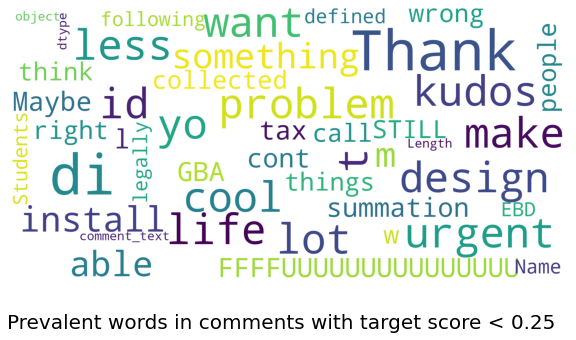

In [66]:
show_wordcloud(train.loc[train['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

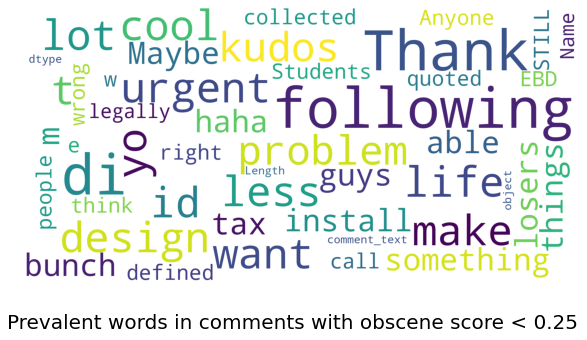

In [67]:
show_wordcloud(train.loc[train['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

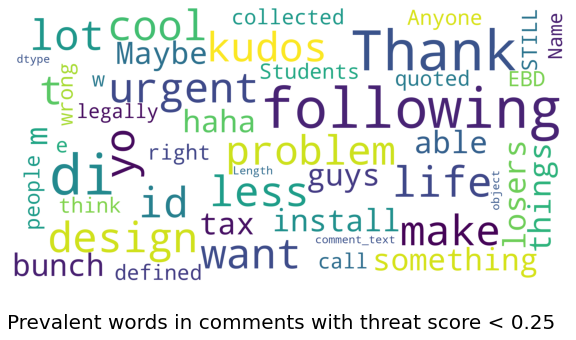

In [68]:
show_wordcloud(train.loc[train['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

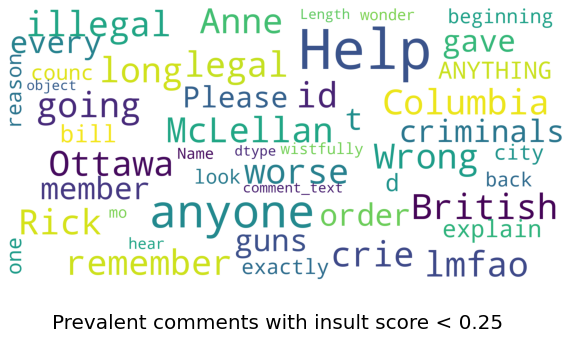

In [69]:
show_wordcloud(train.loc[train['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

#**Preprocessing Text**

In [70]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akash\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [71]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
   #converting everything to lower case.
    text_string = text_string.lower() 
      #removing special character and punctuation
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) 
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [72]:
%%time
train['preprocessed_text']=train['comment_text'].apply(preprocess)

Wall time: 17min 33s


In [73]:
train.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


In [74]:
%%time
test_df['preprocessed_text']=test_df['comment_text'].apply(preprocess)

Wall time: 35.1 s


In [75]:
test_df.head()

,comment_text,preprocessed_text
id,,
7097320,[ Integrity means that you pay your debts.]\n\...,integr mean pay debt appli presid trump
7097321,This is malfeasance by the Administrator and t...,malfeas administr board wast money
7097322,@Rmiller101 - Spoken like a true elitist. But ...,rmiller101 spoken like true elitist look bud a...
7097323,"Paul: Thank you for your kind words. I do, in...",paul thank kind word inde strong belief hide b...
7097324,Sorry you missed high school. Eisenhower sent ...,sorri miss high school eisenhow sent troop vie...


In [76]:
from sklearn.model_selection import train_test_split
feature=train[['preprocessed_text']]
output=train[['target']]

X_train, X_val, Y_train, Y_val=train_test_split(feature,output)

In [77]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [78]:
print(X_train.head())
print(X_val.head())

                                         preprocessed_text
id                                                        
698820        intellig communiti concern trump link russia
5900299                      reason unlaw circumv congress
5154586  shelter alreadi across street colleg calm peop...
5951680  wonder sever 1962 break could one combin 1957 ...
5965281  caution assert germani approach social welfar ...
                                         preprocessed_text
id                                                        
6180544  constitut protect us public opinion minor way ...
6032281                                            insecur
596896               rule etiquett noth pro life pro choic
6229675  tax revenu 2000 year bush elect 2 025 trillion...
5915080  nobodi author real knowledg say everi singl st...


In [79]:
X_test=test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


## **Training Models**

### **1) Bag of Words (BoW)**

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer(ngram_range=(1,2), max_features=30000)
train_bow=count_vect.fit_transform(X_train['preprocessed_text'])
val_bow=count_vect.transform(X_val['preprocessed_text'])
test_bow=count_vect.transform(X_test['preprocessed_text'])

print(train_bow.shape)
print(val_bow.shape)
print(test_bow.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


## **Decision Tree :**

**Hyperparameter Tuning**

In [81]:
#Performing hyperparameter tuning:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,roc_curve,auc,mean_squared_error
max_depth=[3,5,7]
min_samples=[10,100,1000]
xticks=[]
training_err=[]
valid_err=[]
best_model=None
best_err=100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth-"+str(d) + 'Min Samples leaf-' +str(samp))
        print("Depth-" +str(d) + 'Min Samples leaf-' + str(samp) + " :")

    model=DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
    model.fit(train_bow,Y_train)#fitting the trainng data for training
    
    preds = model.predict(train_bow) # Get prediction
    error = mean_squared_error(Y_train['target'], preds) # Calculate error on trainset
    training_err.append(error)
    print("Mean Squared Error on train set: ", error)

    preds=model.predict(val_bow)#getting the prediction on validation set
    error= mean_squared_error(Y_val['target'],preds)#calculate error on validation test
    valid_err.append(error)
    print("Mean squared error on validation  set: ",error)

    if error<best_err:
        best_err=error
        best_model=model
    print("*"*50)

Depth-3Min Samples leaf-10 :
Mean Squared Error on train set:  0.033107251487300586
Mean squared error on validation  set:  0.03310273132341239
**************************************************
Depth-3Min Samples leaf-100 :
Mean Squared Error on train set:  0.033107251487300586
Mean squared error on validation  set:  0.03310273132341239
**************************************************
Depth-3Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03310947241565143
Mean squared error on validation  set:  0.0331042527655668
**************************************************
Depth-5Min Samples leaf-10 :
Mean Squared Error on train set:  0.03202942864279411
Mean squared error on validation  set:  0.03202925355308371
**************************************************
Depth-5Min Samples leaf-100 :
Mean Squared Error on train set:  0.03203307649055723
Mean squared error on validation  set:  0.0320260732664782
**************************************************
Depth-5Min Samples leaf-10

In [83]:
import joblib
joblib.dump(model,'toxicity_model_pipeline.pkl')

['toxicity_model_pipeline.pkl']

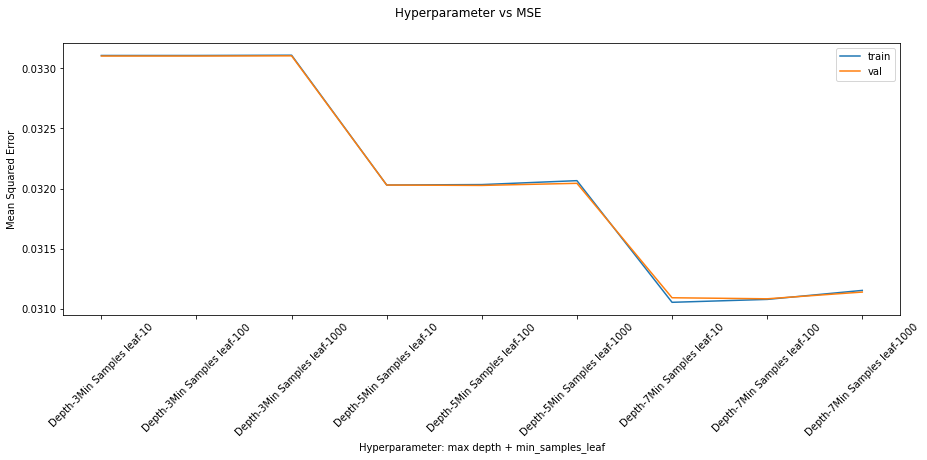

In [84]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameter vs MSE")
plt.plot(range(len(max_depth)* len(min_samples)), training_err)
plt.plot(range(len(max_depth)* len(min_samples)),valid_err)
plt.legend(['train','val'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()


In [85]:
feat_names = count_vect.get_feature_names()
weights=best_model.feature_importances_
df=pd.DataFrame(data=weights,columns=['weights'], index=feat_names)
df.sort_values("weights",ascending=False).iloc[0:20,:]

,weights
stupid,0.399177
idiot,0.264126
pathet,0.070269
fool,0.067868
moron,0.063114
racist,0.059592
hypocrit,0.055199
would,0.003788
year,0.003674
one,0.003612


## **TF-IDF: Term Frequency - Inverse Document Frequency:**

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tf_idf_train=tf_idf_vect.fit_transform(X_train['preprocessed_text'])
tf_idf_val=tf_idf_vect.transform(X_val['preprocessed_text'])
tf_idf_test=tf_idf_vect.transform(X_test['preprocessed_text'])

print(tf_idf_train.shape)
print(tf_idf_val.shape)
print(tf_idf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


## **Decision Tree After Tf-idf**

In [87]:
#Performing hyperparameter tuning:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,roc_curve,auc,mean_squared_error
max_depth=[3,5,7]
min_samples=[10,100,1000]
xticks=[]
training_err=[]
valid_err=[]
best_model=None
best_err=100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth-"+str(d) + 'Min Samples leaf-' +str(samp))
        print("Depth-" +str(d) + 'Min Samples leaf-' + str(samp) + " :")

    model2=DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
    model2.fit(tf_idf_train,Y_train)#fitting the trainng data for training
    
    preds = model2.predict(tf_idf_train) # Get prediction
    error = mean_squared_error(Y_train['target'], preds) # Calculate error on trainset
    training_err.append(error)
    print("Mean Squared Error on train set: ", error)

    preds=model2.predict(tf_idf_val)#getting the prediction on validation set
    error= mean_squared_error(Y_val['target'],preds)#calculate error on validation test
    valid_err.append(error)
    print("Mean squared error on validation  set: ",error)

    if error<best_err:
        best_err=error
        best_model=model2
    print("*"*50)


Depth-3Min Samples leaf-10 :
Depth-3Min Samples leaf-100 :
Depth-3Min Samples leaf-1000 :
Mean Squared Error on train set:  0.0329028906480517
Mean squared error on validation  set:  0.03289702993619692
**************************************************
Depth-5Min Samples leaf-10 :
Depth-5Min Samples leaf-100 :
Depth-5Min Samples leaf-1000 :
Mean Squared Error on train set:  0.031786840655533534
Mean squared error on validation  set:  0.03177681005328476
**************************************************
Depth-7Min Samples leaf-10 :
Depth-7Min Samples leaf-100 :
Depth-7Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03080934832182381
Mean squared error on validation  set:  0.030804004328174563
**************************************************


In [89]:
import joblib
joblib.dump(model2,'toxicity_model_pipeline2.pkl')

['toxicity_model_pipeline2.pkl']

ValueError: x and y must have same first dimension, but have shapes (9,) and (3,)

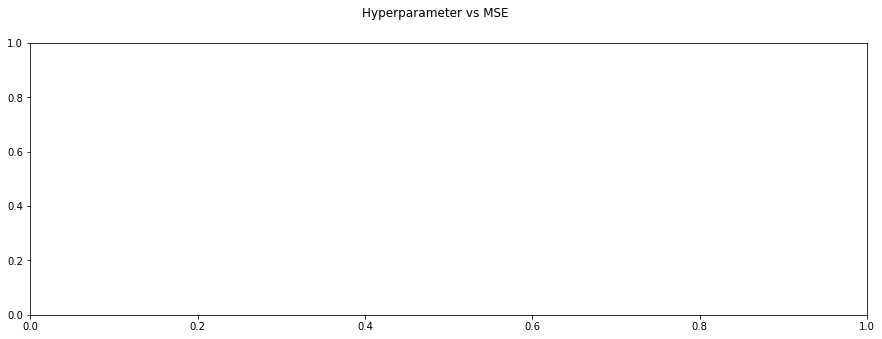

In [90]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameter vs MSE")
plt.plot(range(len(max_depth)* len(min_samples)), training_err)
plt.plot(range(len(max_depth)* len(min_samples)),valid_err)
plt.legend(['train','val'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()


In [91]:
feat_names = count_vect.get_feature_names()
weights=best_model.feature_importances_
df=pd.DataFrame(data=weights,columns=['weights'], index=feat_names)
df.sort_values("weights",ascending=False).iloc[0:20,:]

,weights
stupid,0.409054
idiot,0.266711
pathet,0.071856
fool,0.071512
moron,0.063142
white,0.058120
hypocrit,0.054310
racist,0.005295
presid sinc,0.000000
presid say,0.000000


#**LSTM- LONG SHORT TERM MEMORY**

In [92]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [93]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [94]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_val = lstmfeat.transform(X_val['preprocessed_text'])

In [95]:
print(lstm_train.shape)
print(lstm_val.shape)
print(lstm_test.shape)

(1353655, 350)
(451219, 350)
(97320, 350)


In [103]:
!pip install cudnn

ERROR: Could not find a version that satisfies the requirement cudnn
ERROR: No matching distribution found for cudnn


In [106]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model3 = Sequential()
model3.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model3.add(CuDNNLSTM(128, return_sequences=True))
model3.add(CuDNNLSTM(128))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 350, 100)          20160900  
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 350, 128)          117760    
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 128)               132096    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,410,885
Trainable params: 20,410,885
Non-trainable params: 0
_________________________________________________________________
None


In [107]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [108]:
history = model3.fit(lstm_train, Y_train, epochs=5,batch_size=2000, 
                     validation_data=(lstm_val,Y_val), verbose = 1, callbacks=callbacks_list)

Epoch 1/5


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node sequential_2/cu_dnnlstm_2/CudnnRNNV2}} with these attrs: [seed=0, dropout=0, input_mode="linear_input", T=DT_FLOAT, direction="unidirectional", rnn_mode="lstm", is_training=true, seed2=0]
Registered devices: [CPU]
Registered kernels:
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_DOUBLE]

	 [[sequential_2/cu_dnnlstm_2/CudnnRNNV2]] [Op:__inference_train_function_10883]

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)